<h1>Бизнес-отчёт находится&nbsp;<a href="https://kucheryavykh-data-analyst.blogspot.com/2024/04/ab-gamedev.html" target="_blank" rel="noopener">здесь</a></h1>

<h1 data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Описание A/B-теста</h1>
<p></p>
<p></p>
<div>В компании, которая разрабатывает игры, есть основной хит - бесплатный командный онлайн-шутер. В игре есть внутриигровая валюта, которую можно получить, побеждая в матчах, или покупать за донат. На днях в игре прошёл A/B-тест - некоторые игроки могли приобрести премиальную броню по скидке. Необходимо узнать, как это повлияло на ARPU (средняя прибыль на игрока), ARPPU (средняя прибыль на платящего игрока) и траты внутриигровой валюты.</div>

<h2 data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Цель исследования</h2>
<p></p>
<p></p>
<div>Выяснить, стоит ли проводить акцию в дальнейшем - предоставить статистически значимые выводы об изменении метрик ARPU, ARPPU и трат внутриигровой валюты за период проведения теста. Проанализировать собранные данные с использованием бизнес-правил и математической статистики. Если игроки, участвовавшие в акции, принесли больше денег, чем игроки, у которых акции не было, то стоит масштабировать акцию.</div>

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Заметки</span></h3>
<div>
<ul data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<p></p>
<p></p>
<li>Среди игроков есть читеры - игроки, которые с помощью взлома игры начисляют себе большие объёмы внутриигровой валюты. Есть список известных читеров, но есть и ещё не пойманные читеры, чьи результаты могут повлиять на выводы</li>
<li>Существует 3 категории пользователей в зависимости от игровой платформы - PC, PS4, XBox</li>
</ul>
</div>

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">План анализа</span></h3>
<div>
<ol data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<p></p>
<p></p>
<li>Описать структуру данных</li>
<li>Проверить выполнение предпосылок для анализа A/B-теста</li>
<li>Выявить новых читеров, очистить данные от всех известных читеров</li>
<li>Подготовить данные для проведения статистических тестов</li>
<li>Проверить разницу средних и доверительных интервалов сумм донатов и трат внутриигровой валюты</li>
<li>Рассчитать метрики (ARPU, ARPPU)</li>
<li>Визуализировать временные ряды для исследуемых метрик</li>
<li>Сделать выводы</li>
</ol>
</div>

________________________________________________________________________________________________________________________________

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Структура данных</span></h3>
<p></p>
<p></p>
<div>Данные хранятся на MySQL-сервере в следующих таблицах:</div>
<div>
<ul data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<p></p>
<p></p>
<li>Money - таблица с платежами (донатами)</li>
<li>Cheaters - таблица с известными читерами</li>
<li>Platforms - таблица с игровыми платформами (PC, PS4, XBox)</li>
<li>Cash - таблица с тратами внутриигровой валюты</li>
<li>ABgroup - таблица с распределением игроков по группам тест</li>
</ul>
</div>

In [1]:
#импортирование библиотек

# установка доп. пакетов:
#!pip install PyMySQL
#!pip install simple-colors

import sqlalchemy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pymysql
import scipy.stats as st
import mplcyberpunk #стиль для matplotlib
from simple_colors import * # для форматирования текста
import inspect # для вывода названия переменных

In [2]:
#подключение к БД

host = 'localhost'
user = 'root'
password = '123'
port = '3306'
base = 'arpu'

conn = f'mysql+pymysql://{user}:{password}@{host}:{port}/{base}'
engine = sqlalchemy.create_engine(conn)
connect = engine.connect()
metadata = sqlalchemy.MetaData()

In [3]:
#загрузка в блокнот таблиц из БД

platforms = pd.read_sql('platforms', connect)
platforms.drop_duplicates(inplace=True) # очищаем от дупликатов т.к. в исходниках они есть

money = pd.read_sql('money', connect)
money.drop_duplicates(inplace=True)

cash = pd.read_sql('cash', connect)
cash.drop_duplicates(inplace=True)

abgroup = pd.read_sql('abgroup', connect)
abgroup.drop_duplicates(inplace=True)

In [4]:
def retrieve_name(var): # функция для вывода названия переменной
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# вывод данных о таблицах

for table in [platforms, money, cash, abgroup]:
    print(black(retrieve_name(table)[0], ['bold', 'underlined']), '\n') # функция вывода названия переменной используется здесь
    print(black('head:', 'bold'))
    print(table.head(), '\n')
    print(black('info:', 'bold'))
    print(table.info(), '\n')
    print(black('describe:', 'bold'))
    print(table.describe(), '\n\n\n\n\n')

platforms 

head:
         user_id platform
0  NHFL0F-Y90OSH     XBox
1  MVPNHS-PBHB8S     XBox
2  1UWMRN-8NVCLI       PC
3  EHO5II-03X9PU      PS4
4  7C5ZAE-D1NCY9     XBox 

info:
<class 'pandas.core.frame.DataFrame'>
Index: 1080000 entries, 0 to 7343995
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   user_id   1080000 non-null  object
 1   platform  1080000 non-null  object
dtypes: object(2)
memory usage: 24.7+ MB
None 

describe:
              user_id platform
count         1080000  1080000
unique        1080000        3
top     NHFL0F-Y90OSH     XBox
freq                1   360532 





money 

head:
         user_id        date  money
0  N4TS2T-P7YTVX  15.07.2021   1.99
1  NX9S0D-VM20W8  16.07.2021   0.99
2  QYY6FW-FKHRND  15.07.2021   0.00
3  BRWH4Y-LPGBU6  14.07.2021   0.00
4  8O317F-4ASK53  13.07.2021   0.00 

info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640000 entries, 0 to 8639999
Data columns (

<h3>Описание структуры таблиц</h3>
<p></p>
<p></p>
<table border="1" style="border-collapse: collapse; width: 90.6295%; height: 170px;">
<tbody>
<tr style="height: 18px;">
<td style="width: 10%; height: 18px; text-align: left;">Таблица</td>
<td style="width: 8%; height: 18px; text-align: right;">Размер (срок)</td>
<td style="width: 13%; height: 18px;">Что хранит</td>
<td style="width: 11%; height: 18px; text-align: left;">Колонки</td>
<td style="width: 6%; height: 18px; text-align: left;">Тип данных</td>
<td style="width: 13%; height: 18px; text-align: left;">Интерпретация</td>
<td style="width: 38%; height: 18px; text-align: right;">Пример данных</td>
</tr>
<tr style="height: 11px;">
<td style="width: 10.5123%; height: 29px; text-align: left;" rowspan="2">platforms</td>
<td style="width: 8.4973%; text-align: right; height: 29px;" rowspan="2">1.080.000</td>
<td style="width: 8.4973%; height: 29px; text-align: left;" rowspan="2">Распределение игроков по платформам</td>
<td style="width: 11.4281%; height: 11px; text-align: left;">user_id</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">уникальный номер пользователя</td>
<td style="width: 38.321%; height: 29px; text-align: right;" rowspan="2">
<pre>         user_id platform
0  NHFL0F-Y90OSH     XBox
1  MVPNHS-PBHB8S     XBox
2  1UWMRN-8NVCLI       PC
3  EHO5II-03X9PU      PS4
4  7C5ZAE-D1NCY9     XBox</pre>
</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">platform</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">название игровой платформы</td>
</tr>
<tr style="height: 11px;">
<td style="width: 10.5123%; height: 47px; text-align: left;" rowspan="3">money</td>
<td style="width: 8.4973%; text-align: right; height: 47px;" rowspan="3">8.640.000</td>
<td style="width: 8.4973%; height: 47px; text-align: left;" rowspan="3">Транзакции донатов</td>
<td style="width: 11.4281%; height: 11px; text-align: left;">user_id</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">уникальный номер пользователя</td>
<td style="width: 38.321%; height: 47px; text-align: right;" rowspan="3">
<pre>        user_id        date  money
0  N4TS2T-P7YTVX  15.07.2021   1.99
1  NX9S0D-VM20W8  16.07.2021   0.99
2  QYY6FW-FKHRND  15.07.2021   0.00
3  BRWH4Y-LPGBU6  14.07.2021   0.00
4  8O317F-4ASK53  13.07.2021   0.00 </pre>
</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">дата</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">дата</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">дата транзакции</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">money</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">число</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">сумма доната в транзакции</td>
</tr>
<tr style="height: 11px;">
<td style="width: 10.5123%; height: 47px; text-align: left;" rowspan="3">cash</td>
<td style="width: 8.4973%; text-align: right; height: 47px;" rowspan="3">8.640.000</td>
<td style="width: 8.4973%; height: 47px; text-align: left;" rowspan="3">Транзакции трат внутриигровой валюты</td>
<td style="width: 11.4281%; height: 11px; text-align: left;">user_id</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">уникальный номер пользователя</td>
<td style="width: 38.321%; height: 47px; text-align: right;" rowspan="3">
<pre>         user_id        date  cash
0  GGLSXL-U5BGGY  17.07.2021   200
1  DPWFFN-NL3VF8  16.07.2021   150
2  PASNNG-GVW4RR  11.07.2021  1100
3  4F0AW7-F40GY9  15.07.2021  1050
4  CEY6AF-YTSM4V  15.07.2021   150 </pre>
</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">дата</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">дата</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">дата транзакции</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">cash</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">число</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">сумма траты в транзакции</td>
</tr>
<tr style="height: 11px;">
<td style="width: 10.5123%; height: 29px; text-align: left;" rowspan="2">abgroup</td>
<td style="width: 8.4973%; text-align: right; height: 29px;" rowspan="2">208.164</td>
<td style="width: 8.4973%; height: 29px; text-align: left;" rowspan="2">Распределение игроков по группам A/B-тестирования</td>
<td style="width: 11.4281%; height: 11px; text-align: left;">user_id</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 11px; text-align: left;">уникальный номер пользователя</td>
<td style="width: 38.321%; height: 29px; text-align: right;" rowspan="2">
<pre>         user_id    group
0  VX6NLA-F5YMSW  control
1  2AXN3D-71ZN86     test
2  K78V3J-TQMV6F     test
3  Z2KEIG-LY3V4H     test
4  ND92RZ-SHG980  control </pre>
</td>
</tr>
<tr style="height: 18px;">
<td style="width: 11.4281%; height: 18px; text-align: left;">group</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">строка</td>
<td style="width: 6.68675%; height: 18px; text-align: left;">к какой группе принадлежит</td>
</tr>
</tbody>
</table>

<div>
<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Проверка выполнения предпосылок</span></h3>
</div>
<p></p>
<p></p>
<div>Данные были проверены на предмет равномерности распределения кол-ва пользователей между группами тестирования платформами - требование выполняется (распределение равномерное):</div>

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


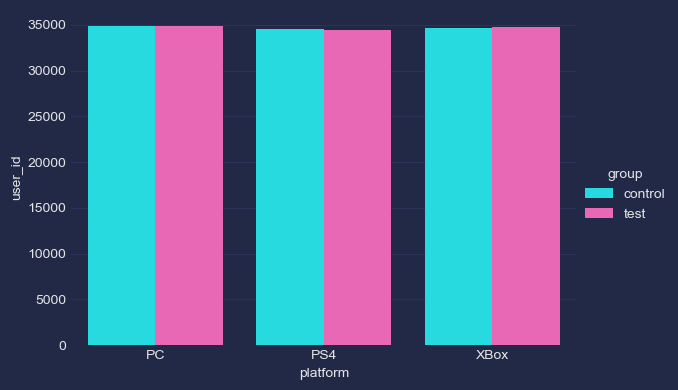

In [5]:
# мерджим данные о платформах пользователей и групп тестирования, левое соединение т.к. отбираем только тех, кто участвует в эксперименте

ab_platforms_dist = pd.merge(abgroup, platforms, left_on='user_id', right_on='user_id')

plt.style.use("cyberpunk")

# группируемся по группе тестирование и платформе, выводим распределение

ab_platforms_dist = ab_platforms_dist.groupby(by=['group', 'platform']).user_id.count().reset_index()
ax = sns.catplot(x='platform', y='user_id', hue='group',
                 data=ab_platforms_dist, kind='bar', height=4, aspect=1.5)
plt.show()

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Выявление читеров</span></h3>
<p></p>
<p></p>
<div>Логика выявления читеров состоит в том, чтобы найти тех, кто неадекватно тратит игровую валюту, и при этом не донатит. Идея в том, что тратить валюту и не донатить - нормально, ведь валюту можно получить за победу в играх, но распределение сумм трат в таком случае будет однородным. На практике же получается следующее:</div>

In [6]:
# отбираем кандидатов в читеры - это пользователи, кто не донатил, но тратил внутриигровую валюту

money_value = money.groupby(['user_id']).agg({'money': 'sum'}) # находим сумму донатов по ID юзера
cash_value = cash.groupby(['user_id']).agg({'cash': 'sum'}) # находим сумму трат по ID юзера
money_value_on = money_value[money_value['money'] == 0] # берём не донативших
cash_value_on = cash_value[cash_value['cash'] != 0] # но тративших внутриигровую валюту

<Axes: >

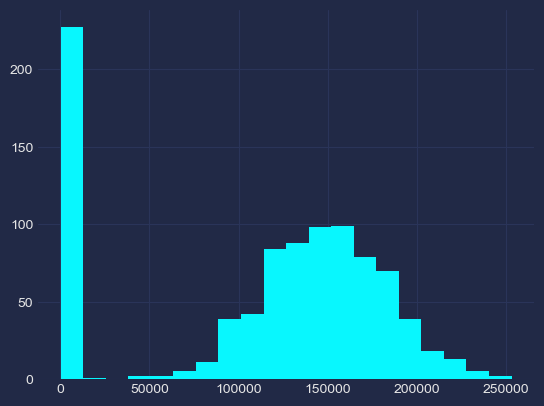

In [7]:
#распределение кол-ва потраченной валюты у таких игроков
plt.style.use("cyberpunk")

potential_cheaters = pd.merge(money_value_on, cash_value_on, how='left', left_on='user_id', right_on='user_id').reset_index()

potential_cheaters['cash'].hist(bins=20)

<div>Заметно, что после определённого уровня трат валюты распределение принимает нормальный вид, хотя до этого напоминало скорее гамма-распределение (т.е. является неоднородным, что сигнализирует о наличии читеров). Взглянув на участок распределения, где начинаются странности, отсечка, по которой можно определить читера, становится понятной (5.650):</div>

In [8]:
#находим с какого значения траты становятся неадекватными

potential_cheaters = potential_cheaters.sort_values(by='cash')
cheaters_redline = potential_cheaters[potential_cheaters['cash'] > 5000]['cash'].head(10).reset_index().drop('index', axis = 1)
cheaters_redline

,cash
0,5250
1,5350
2,5600
3,5650
4,20700
5,46700
6,50150
7,55800
8,61950
9,64900


<div>
<div>Следовательно, <strong>читерами считаем тех, кто</strong> в рассматриваемом периоде:</div>
<div>
<ul data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<li><strong>Не донатил</strong></li>
<li><strong>Потратил валюты больше, чем 5.650 у.е.</strong></li>
</ul>
</div>
</div>

<p>При этом следует убедиться, что логика работает корректно. Для этого <strong>проверим нашли ли мы нашим способом тех читеров, кто уже был известен?</strong></p>

In [9]:
# отбор выявленных читеров, выводим их кол-во
true_cheaters = potential_cheaters[potential_cheaters['cash'] > 5650]['user_id']
true_cheaters.describe()

count               697
unique              697
top       4DBX3L-2LHKON
freq                  1
Name: user_id, dtype: object

In [10]:
#получение списка известных читеров, вывод их кол-ва

sql_query_known_cheaters = sqlalchemy.text("""select user_id from cheaters where cheaters=1""")

with engine.begin() as connector:
    known_cheaters = pd.read_sql_query(sql=sql_query_known_cheaters, con=connector)

known_cheaters.drop_duplicates(inplace=True)
known_cheaters.describe()

,user_id
count,353
unique,353
top,9WIF40-OW5GLD
freq,1


In [11]:
# проверим нашли ли мы в том числе уже известных читеров
# найдём пересечения во множестве ID пользователей из найденных нашим способом читеров и множестве тех, кто уже был известен
# если число пересечений и число известных читеров совпадает, то логика поиска работает корректно
# т.е. в уже известных читерах нет таких, которых мы бы не нашли
# в этом случае число пересечений было бы меньше, чем число известных - мол есть такие, для которых в списке найденных не нашлось пары (пересечения)

cheaters_id_intersection = set(true_cheaters) & set(known_cheaters['user_id'])
len(cheaters_id_intersection)

# совпадает (353) - логика корректна

353

In [12]:
#загрузка списка читеров в MySQL и присваивание итоговой переменной списку найденных читеров

# true_cheaters = true_cheaters.to_frame(name='user_id')
# true_cheaters['user_id'].to_sql('correct_cheaters', connect, if_exists='append', index=False)

cheaters = true_cheaters #присвоим более простую переменную корректному списку читеров

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Подготовка данных</span></h3>
<p></p>
<p></p>
<div>Для выполнения тестов:</div>
<div>
<ul data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<li>Объединим таблицы Money и Cash (отдельно друг от друга) с таблицами Platforms и ABgroup, тем самым в разрезе User_id, игровой платформы пользователя и принадлежности пользователя к группе A/B-теста получим данные о сумме донатов и трат игровой валюты пользователя</li>
<li>Создадим словарь, где в ключах находятся интересующие для исследования группы, а в значениях - списки из сумм трат валюты или донатов. Итерация по парам ключей из словаря дают те группы значений, к которым необходимо применить статистические тесты для анализа результатов A/B-теста.</li>
</ul>
</div>

In [13]:
# подготовка данных для статистических тестов

#объединение данных

#добавление информации о принадлежности пользователя к группе тестирования
money_group = pd.merge(money, abgroup, on='user_id', how='left')
cash_group = pd.merge(cash, abgroup, on='user_id', how='left')

#добавление информации о платформе пользователя
money_group_platform = pd.merge(money_group, platforms, on='user_id', how='left')
cash_group_platform = pd.merge(cash_group, platforms, on='user_id', how='left')

In [14]:
#очистка данных от читеров
money_cheaters = money_group_platform[money_group_platform["user_id"].isin(cheaters)]
money_group_platform = pd.concat([money_group_platform, money_cheaters])
money_group_platform.drop_duplicates(inplace=True, keep=False)

cash_cheaters = cash_group_platform[cash_group_platform["user_id"].isin(cheaters)]
cash_group_platform = pd.concat([cash_group_platform, cash_cheaters])
cash_group_platform.drop_duplicates(inplace=True, keep=False)

#!!! в таблицах money_group и cash_group остаются строки с читерами т.к. далее мы эти таблицы не используем !!!

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Статистические тесты</span></h3>
<p></p>
<p></p>
<div>Статистический критерий выбран из следующих предпосылок:</div>
<p></p>
<p></p>
<div>
<ul data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<li>Вид данных &ldquo;платежи&rdquo; (относится и к внутриигровой валюте) является количественным дискретным т.к.:</li>
<ul>
<li>Платеж ограничен точностью до центов/копеек и, несмотря на то, что он представлен в виду дробного числа, может быть выражен кол-ом целых частей (кол-во копеек/центов)</li>
<li>Интервалы между единицами измерения одинаковы на всей протяженности шкалы</li>
</ul>
<li>Выборки являются независимыми (поперечными)</li>
<li>Выборки являются большими (около 1.5 млн. испытаний в каждой группе) - действует ЗБЧ (Закон Больших Чисел). Следовательно, можно игнорировать вид распределения и считать его нормальным</li>
<li>Разница дисперсий небольшая (до 0.05)</li>
<li>Bootstrap не используем т.к. его эффективность необходима только для небольших выборок</li>
<li>Критерий Манна-Уитни не используем т.к. он является критерием однородности (<a data-original-attrs="{&quot;data-original-href&quot;:&quot;https://habr.com/ru/companies/avito/articles/709596/&quot;,&quot;target&quot;:&quot;_blank&quot;}" href="https://habr.com/ru/companies/avito/articles/709596/">хабр-статья</a>)</li>
</ul>
<div>По Стентону Гланцу - "Медико-биологическая статистика", при данных предпосылках подходит<span>&nbsp;</span><b>t-тест</b>:</div>
<div>&nbsp;
<table border="1">
<tbody>
<tr data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}" rowspan="2">Вид переменной</td>
<td colspan="2" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Поперечный (независимые выборки)</td>
</tr>
<tr data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Две группы</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Несколько групп</td>
</tr>
<tr data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Количественная (нормальное распределение)</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><b>Критерий Стьюдента</b></span></td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Дисперсионный анализ</td>
</tr>
<tr data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Порядковая и количественная (распределение, отличное от нормального)</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Критерий Манна-Уитни</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Критерий Крускала-Уоллиса</td>
</tr>
<tr data-original-attrs="{&quot;style&quot;:&quot;&quot;}">
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Качественная, номинальная</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Критерий хи-квадрат</td>
<td data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Критерий хи-квадрат</td>
</tr>
</tbody>
</table>
</div>
<div></div>
<p></p>
<p></p>
<div>Но мы так же проверим <b>доверительные интервалы</b> для более легкой интерпретации результатов.</div>
<p></p>
<p></p>
<div><b>Статистическая значимость = 0.05 (95%)</b></div>
</div>

<h3>Гипотезы</h3>
<p></p>
<p></p>
<div><b>Ho</b><span>&nbsp;</span>(нулевая): средняя сумма (доната или траты внутриигровой валюты) в группах не различаются</div>
<div><b>Ha</b><span>&nbsp;</span>(альтернативная): средние суммы отличаются</div>

In [15]:
#проверка статистической значимости данных

# подготовка списков (выборок)

dimensions = [column for column in money_group_platform][3:] # получаем список из интересующих нас измерений, по которым мы
# будем разрезать невольных участников нашего эксперимента
name = 'list_money' # префикс для названия группы (сейчас по донатам, ниже будет по тратам внутриигровой валюты)
iterable_dict = {} # словарь, где в ключах будут измерения, по которым мы будем нарезать пользователей,
# а в значениях уникальные значения этих измерений
samples_list = [] # список, куда мы положим нарезки (списки) комбинаций измерений
samples = {} # словарь, куда будем складывать выборки как значения по ключам - разрезам пользователей

for dimension in dimensions:
    values_list = list(money_group_platform[dimension].unique()) # отбираем уникальные значения каждого изверения
    # т.е. уникальные названия групп тестирования и названий платформ
    my_dict = {dimension: values_list} # для каждого измерения
    iterable_dict.update(my_dict) # записываем его уникальные значения

groups_list = list(iterable_dict.values())[0] # получаем что у нас вышло - список уникальных групп тестирования
platforms_list = list(iterable_dict.values())[1] # и список уникальных платформ

for group in groups_list:
    samples_list.append([group, platforms_list]) # нарезаем комбинации группы тестирования и все платформы

for group in samples_list: # итерируемся по списку комбинаций измерений (для каждой группы тестирования)
    group_name = group[0] # берём группу
    for platform in group[1]: # и внутри группы берём каждую платформу
        file_name = str(name + '_' + str(group_name) + '_' + str(platform)) # создаём название ключа для выборки,
        # к которой мы будем применять стат. тесты
        my_dict = {file_name: list(money_group_platform[(money_group_platform['group'] == group_name)\
                                               & (money_group_platform['platform'] == platform)]['money'])}
        # создаём выборку значений сумм донатов для интересующего нас разреза пользователей
        samples.update(my_dict) # записываем её

# делаем тоже самое, только здесь разрез пользователей проще - это просто все пользователи
d1 = {'list_money_test_all': list(money_group_platform[(money_group_platform['group'] == 'test')]['money'])}
d2 = {'list_money_control_all': list(money_group_platform[(money_group_platform['group'] == 'control')]['money'])}

# их тоже добавляем в список выборок, как отдельную группу
samples.update(d1)
samples.update(d2)

# наверное, конечно, было бы проще получить уникальные значения и в ручную создать все варианты комбинаций измерений
# но хотелось сделать что-то универсальное

<p>Теперь мы можем на основании названия группы достаточно просто применить все интересующие нас тесты</p>

In [16]:
#проверка разности дисперсий для t-критерия Стьюдента

test_group_names = [] # список из названий тестовых групп
control_group_names = [] # список из названий контрольных групп

# добавляем в них те разрезы пользователей, которые содержат ключевые слова
for sample_name in list(samples.keys()): # собственно здесь и начинается применение нашего словаря - сначала по ключам
    if 'test' in sample_name:
        test_group_names.append(sample_name)
    elif 'control' in sample_name:
        control_group_names.append(sample_name)

if len(test_group_names) == len(control_group_names): # на всякий случай проверяем что каждую группу есть с чем сравнить
    for index in range(len(control_group_names)): # итерируемся по счётчику т.к. нужно будет брать из каждой группы
        # первое, второе и т.д. значения - сейчас знаю что это можно было бы сделать через zip и двойную итерацию
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name] # получаем выборки значений, к которым будем применять стат. тест
        control_sample_values = samples[control_sample_name]
        print('\n' + 'Сравниваем группы:\n' + str(test_sample_name) + '\n' + str(control_sample_name))
        diff = pd.Series(samples[test_sample_name]).std() - pd.Series(samples[control_sample_name]).std() # разница дисперсий
        print('Разница дисперсий =', round(diff, 5))


Сравниваем группы:
list_money_test_PS4
list_money_control_PS4
Разница дисперсий = 0.03148

Сравниваем группы:
list_money_test_XBox
list_money_control_XBox
Разница дисперсий = 0.00466

Сравниваем группы:
list_money_test_PC
list_money_control_PC
Разница дисперсий = 0.05354

Сравниваем группы:
list_money_test_all
list_money_control_all
Разница дисперсий = 0.02935


In [17]:
# проверка статистической значимости данных

# выполнение статистических тестов
# по той же логике итерации

result_dict = {}
t_results = pd.DataFrame() # только здесь результаты будем не выводить через print, как с дисперсией, а записывать в датафрейм

if len(test_group_names) == len(control_group_names):
    for index in range(len(control_group_names)):
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name]
        control_sample_values = samples[control_sample_name]
        result_dict['group_1'] = str(test_sample_name)
        result_dict['group_2'] = str(control_sample_name)
        result_dict['p-value (t-test)'] = st.ttest_ind(test_sample_values, control_sample_values)[1]
        t_results = t_results._append(result_dict, ignore_index = True)
        
t_results

,group_1,group_2,p-value (t-test)
0,list_money_test_PS4,list_money_control_PS4,1.263354e-99
1,list_money_test_XBox,list_money_control_XBox,1.211527e-02
2,list_money_test_PC,list_money_control_PC,2.305225e-295
3,list_money_test_all,list_money_control_all,2.402445e-262


In [18]:
#проверка статистической значимости данных для трат внутриигровой валюты
# здесь всё в одной ячейке, по той же логике

# подготовка списков (выборок)

dimensions_cash = [column for column in cash_group_platform][3:]
name_cash = 'list_cash' # только теперь префикс с "cash"
iterable_dict_cash = {}
samples_list_cash = []
samples_cash = {}

for dimension in dimensions_cash:
    values_list = list(cash_group_platform[dimension].unique())
    my_dict = {dimension: values_list}
    iterable_dict_cash.update(my_dict)

groups_list_cash = list(iterable_dict_cash.values())[0]
platforms_list_cash = list(iterable_dict_cash.values())[1]

for group in groups_list_cash:
    samples_list_cash.append([group, platforms_list_cash])

for group in samples_list_cash:
    group_name = group[0]
    for platform in group[1]:
        file_name = str(name_cash + '_' + str(group_name) + '_' + str(platform))
        my_dict = {file_name: list(cash_group_platform[(cash_group_platform['group'] == group_name)\
                                               & (cash_group_platform['platform'] == platform)]['cash'])}
        samples_cash.update(my_dict)

d1_cash = {'list_cash_test_all': list(cash_group_platform[(cash_group_platform['group'] == 'test')]['cash'])}
d2_cash = {'list_cash_control_all': list(cash_group_platform[(cash_group_platform['group'] == 'control')]['cash'])}

samples_cash.update(d1_cash)
samples_cash.update(d2_cash)

#проверка разности дисперсий для t-критерия Стьюдента

test_group_names_cash = []
control_group_names_cash = []

for sample_name in list(samples_cash.keys()):
    if 'test' in sample_name:
        test_group_names_cash.append(sample_name)
    elif 'control' in sample_name:
        control_group_names_cash.append(sample_name)

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        print('\n' + 'Сравниваем группы:\n' + str(test_sample_name) + '\n' + str(control_sample_name))
        diff = pd.Series(samples_cash[test_sample_name]).std() - pd.Series(samples_cash[control_sample_name]).std()
        print('Разница дисперсий =', round(diff, 5))


Сравниваем группы:
list_cash_test_XBox
list_cash_control_XBox
Разница дисперсий = 4.3506

Сравниваем группы:
list_cash_test_PS4
list_cash_control_PS4
Разница дисперсий = 43.59268

Сравниваем группы:
list_cash_test_PC
list_cash_control_PC
Разница дисперсий = 89.48958

Сравниваем группы:
list_cash_test_all
list_cash_control_all
Разница дисперсий = 44.83196


In [19]:
#проверка статистической значимости данных для трат внутриигровой валюты

#выполнение статистических тестов

result_dict_cash = {}
t_results_cash = pd.DataFrame()

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        result_dict_cash['group_1'] = str(test_sample_name)
        result_dict_cash['group_2'] = str(control_sample_name)
        result_dict_cash['p-value (t-test)'] = st.ttest_ind(test_sample_values, control_sample_values)[1]
        t_results_cash = t_results_cash._append(result_dict_cash, ignore_index = True)
        
t_results_cash

,group_1,group_2,p-value (t-test)
0,list_cash_test_XBox,list_cash_control_XBox,1.362097e-04
1,list_cash_test_PS4,list_cash_control_PS4,4.348027e-248
2,list_cash_test_PC,list_cash_control_PC,0.000000e+00
3,list_cash_test_all,list_cash_control_all,0.000000e+00


<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Интерпретация</span></h3>
<p></p>
<p><strong>P-value</strong> для всех пар групп <strong>ниже заданного уровня значимости</strong>, значит нулевая гипотеза отвергается и <strong>принимается альтернативная</strong>.</p>
<p></p>
<div><strong>Статистически значимые различия прослеживаются среди всех групп</strong>, следовательно, <strong>внедрение скидки на премиальную броню действительно повлияло на среднюю сумму донатов и трат внутриигровой валюты</strong> (с принятым уровнем значимости).&nbsp;</div>

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Доверительные интервалы</span></h3>

In [20]:
#проверка доверительных интервалов для донатов

result_interval_dict = {}
interval_results = pd.DataFrame() # запишем точки границ доверительных интервалов в датафрейм

confidence = 0.95

# та же идея с итерацией
if len(test_group_names) == len(control_group_names):
    for index in range(len(control_group_names)):
        test_sample_name = test_group_names[index]
        control_sample_name = control_group_names[index]
        test_sample_values = samples[test_sample_name]
        control_sample_values = samples[control_sample_name]
        
        # получение доверительных интервалов
        interval_test = st.norm.interval(confidence=confidence, loc=np.mean(test_sample_values), scale=st.sem(test_sample_values))
        interval_control = st.norm.interval(confidence=confidence, loc=np.mean(control_sample_values), scale=st.sem(control_sample_values))
        
        # получение точек границ доверительнх интервалов
        low_test = round(interval_test[0], 3)
        high_test = round(interval_test[1], 3)
        low_control = round(interval_control[0], 3)
        high_control = round(interval_control[1], 3)
        result_interval_dict['group_1'] = str(test_sample_name)
        result_interval_dict['group_2'] = str(control_sample_name)
        result_interval_dict['low_test'] = low_test
        result_interval_dict['high_test'] = high_test
        result_interval_dict['low_control'] = low_control
        result_interval_dict['high_control'] = high_control
        if (low_test <= high_control) or (low_control <= high_test):
            result_interval_dict['result'] = 'Интервалы не пересекаются'
        else:
            result_interval_dict['result'] = 'Интервалы пересекаются'
            
        # и их запись в датафрейм
        interval_results = interval_results._append(result_interval_dict, ignore_index = True)
        
interval_results

,group_1,group_2,low_test,high_test,low_control,high_control,result
0,list_money_test_PS4,list_money_control_PS4,0.759,0.765,0.714,0.720,Интервалы не пересекаются
1,list_money_test_XBox,list_money_control_XBox,0.765,0.771,0.760,0.766,Интервалы не пересекаются
2,list_money_test_PC,list_money_control_PC,0.782,0.788,0.705,0.710,Интервалы не пересекаются
3,list_money_test_all,list_money_control_all,0.770,0.773,0.727,0.731,Интервалы не пересекаются


Text(0, 0.5, 'Платформы')

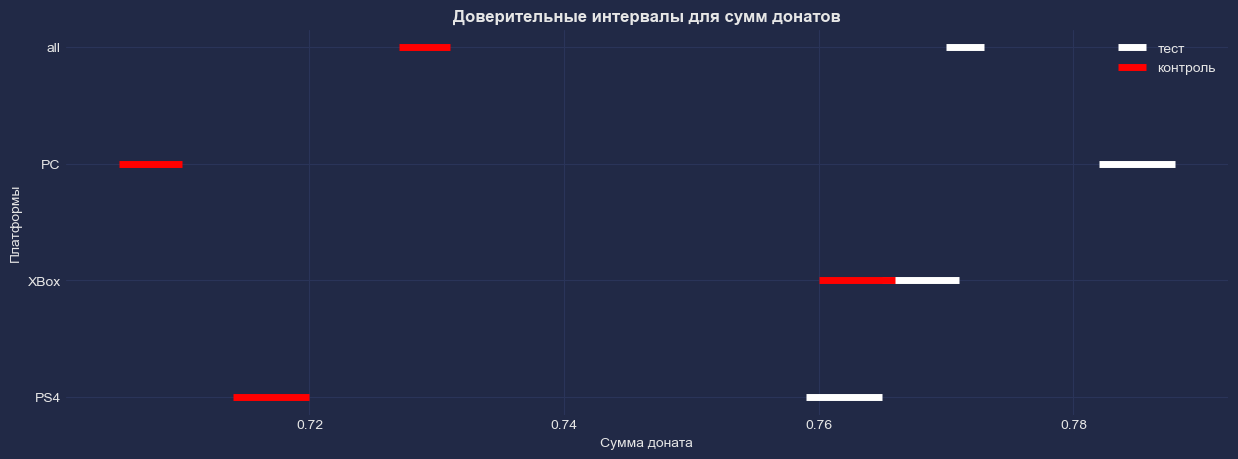

In [21]:
# визуализация доверительных интервалов для донатов
        
fig = plt.figure(figsize = (15, 5))

if len(platforms_list) == 3:
    platforms_list += ['all']
        
plt.hlines(platforms_list,
           interval_results['low_test'],
           interval_results['high_test'],
           color = 'white', linewidth = 5, label='тест')
plt.hlines(platforms_list,
           interval_results['low_control'],
           interval_results['high_control'],
           color = 'red', linewidth = 5, label='контроль')

plt.legend()
plt.title(label='Доверительные интервалы для сумм донатов', fontweight='bold')
plt.xlabel("Сумма доната")
plt.ylabel("Платформы")

In [22]:
# проверка доверительных интервалов для трат внутриигровой валюты

result_interval_dict_cash = {}
interval_results_cash = pd.DataFrame()

confidence = 0.95

if len(test_group_names_cash) == len(control_group_names_cash):
    for index in range(len(control_group_names_cash)):
        test_sample_name = test_group_names_cash[index]
        control_sample_name = control_group_names_cash[index]
        test_sample_values = samples_cash[test_sample_name]
        control_sample_values = samples_cash[control_sample_name]
        interval_test = st.norm.interval(confidence=confidence, loc=np.mean(test_sample_values), scale=st.sem(test_sample_values))
        interval_control = st.norm.interval(confidence=confidence, loc=np.mean(control_sample_values), scale=st.sem(control_sample_values))
        low_test = round(interval_test[0], 3)
        high_test = round(interval_test[1], 3)
        low_control = round(interval_control[0], 3)
        high_control = round(interval_control[1], 3)
        result_interval_dict_cash['group_1'] = str(test_sample_name)
        result_interval_dict_cash['group_2'] = str(control_sample_name)
        result_interval_dict_cash['low_test'] = low_test
        result_interval_dict_cash['high_test'] = high_test
        result_interval_dict_cash['low_control'] = low_control
        result_interval_dict_cash['high_control'] = high_control
        if (low_test <= high_control) or (low_control <= high_test):
            result_interval_dict_cash['result'] = 'Интервалы не пересекаются'
        else:
            result_interval_dict_cash['result'] = 'Интервалы пересекаются'
        interval_results_cash = interval_results_cash._append(result_interval_dict_cash, ignore_index = True)

interval_results_cash

,group_1,group_2,low_test,high_test,low_control,high_control,result
0,list_cash_test_XBox,list_cash_control_XBox,770.180,775.071,763.486,768.345,Интервалы не пересекаются
1,list_cash_test_PS4,list_cash_control_PS4,764.164,769.010,707.458,711.974,Интервалы не пересекаются
2,list_cash_test_PC,list_cash_control_PC,796.993,802.028,697.963,702.332,Интервалы не пересекаются
3,list_cash_test_all,list_cash_control_all,778.199,781.044,723.931,726.582,Интервалы не пересекаются


Text(0, 0.5, 'Платформы')

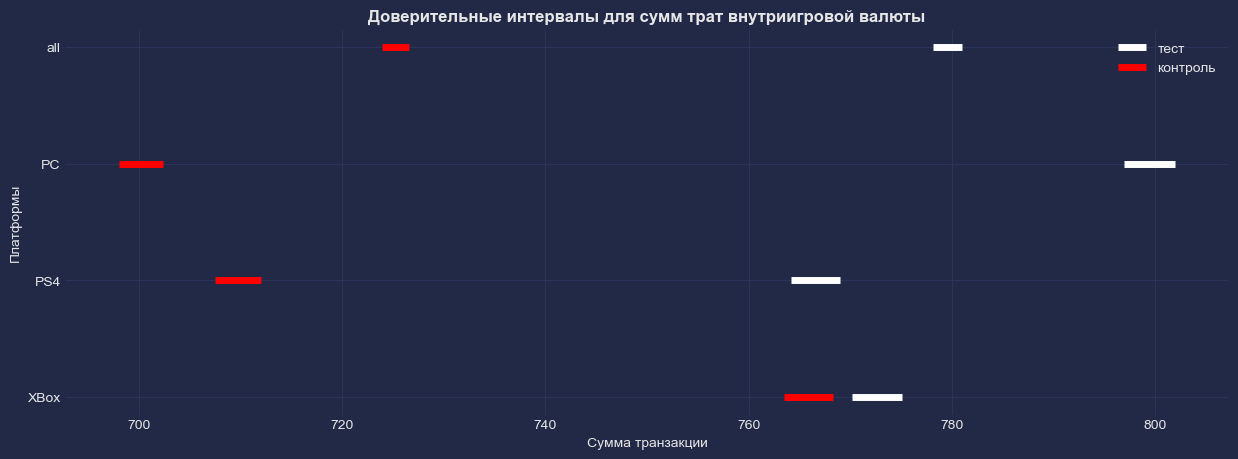

In [23]:
# визуализация доверительных интервалов для трат внутриигровой валюты 

if len(platforms_list_cash) == 3:
    platforms_list_cash += ['all']

fig = plt.figure(figsize = (15, 5))

plt.hlines(platforms_list_cash,
           interval_results_cash['low_test'],
           interval_results_cash['high_test'],
           color = 'white', linewidth = 5, label='тест')
plt.hlines(platforms_list_cash,
           interval_results_cash['low_control'],
           interval_results_cash['high_control'],
           color = 'red', linewidth = 5, label='контроль')

plt.legend()
plt.title(label='Доверительные интервалы для сумм трат внутриигровой валюты', fontweight='bold')
plt.xlabel("Сумма транзакции")
plt.ylabel("Платформы")

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Интерпретация</span></h3>
<p></p>
<div><strong>Наблюдается рост средних как сумм донатов, так и трат внутриигровой валюты</strong> - можно сказать, что гипотеза о том, что <strong>компания заработает больше с внедрением скидки</strong>, верна.</div>
<p></p>
<div>При этом заметно, что <strong>пользователи платформы XBox меньше отреагировали на скидку</strong> - здесь есть потенциал для роста. Но следует быть внимательным т.к. <strong>платформа XBox имеет наивысший средний донат в контрольных группах</strong>.</div>

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Метрики (ARPU, ARPPU)</span></h3>

In [24]:
#расчёт ARPU и ARPPU по донатам - для каждого дня эксперимента

#функция для расчёта метрик - с её помощью будем выполнять группировку в датафрейме
def count_metric(x, metric, data):
    # т.к. мы будем применять группировку на весь список транзакций, из которого далеко не все пользователи
    # принимали участие в эксперименте, нам нужно отобрать только те, у которых есть принадлежность к группе тестирования
    
    result = { # делаем мы это здесь, суммируем единички, которые будем ниже заполнять на основании принадлежности к группе
        # и что важно - каждую в свой столбец для группы, в столбце с названием "тест" - единички для теста, "контроль" - для контроля
        
        # а так как внутри функции мы не знаем из какой группы к нам пришли пользователи,
        # она должна одинаково работать и с тестом и с контролем одинаково
        
        'test_sum': x['test'].sum(), # отбираем колонку с единицами для теста, суммируем
        'control_sum': x['control'].sum() # отбираем колонку с единицами для контроля, суммируем
        # и в этих парах сумма больше нуля будет только у одного из ключей -
        # так как во второй в момент вызова функции никто не попал, ведь группировка идёт по группам эксперимента
    }
    output = {'user_count': sum(result.values())} # поэтому здесь мы можем спокойно суммировать одно с другим и знать, 
    # что неважно по какой группе вызвали функцию - посчитали мы сумму пользователей только по ней
    output[data] = x[data].sum() # считаем сумму донатов (или трат внутриигровой валюты, смотря что передали в функцию)
    
    output[metric] = output[data] / output['user_count'] # и делим на кол-во пользователей - это и есть наша метрика
    return pd.Series(output)


#ARPU
ARPU = pd.DataFrame(money_group_platform)
ARPU['test'] = np.where(ARPU['group'] == 'test', 1, 0) # здесь мы заполняем одноименную колоку единичками на основании
ARPU['control'] = np.where(ARPU['group'] == 'control', 1, 0) # принадлежности к группе
# а здесь выполняем группировку с расчётом метрики
ARPU = ARPU.groupby(by=['group', 'date', 'platform']).apply(lambda x: count_metric(x, 'ARPU', 'money')).reset_index()
ARPU = ARPU.sort_values(by='date')

#ARPPU - сначала отбор только заплативших игроков, затем расчёт (разница в метриках только в этом, поэтому используем ту же функцию)
money_per_user = money_group_platform.groupby(by=['user_id', 'date', 'group', 'platform']).money.sum().reset_index()
ARPPU = money_per_user.drop(money_per_user.loc[money_per_user['money'] == 0].index)
ARPPU['test'] = np.where(ARPPU['group'] == 'test', 1, 0)
ARPPU['control'] = np.where(ARPPU['group'] == 'control', 1, 0)
ARPPU = ARPPU.groupby(by=['group', 'date', 'platform']).apply(lambda x: count_metric(x, 'ARPPU', 'money')).reset_index()
ARPPU = ARPPU.sort_values(by='date')



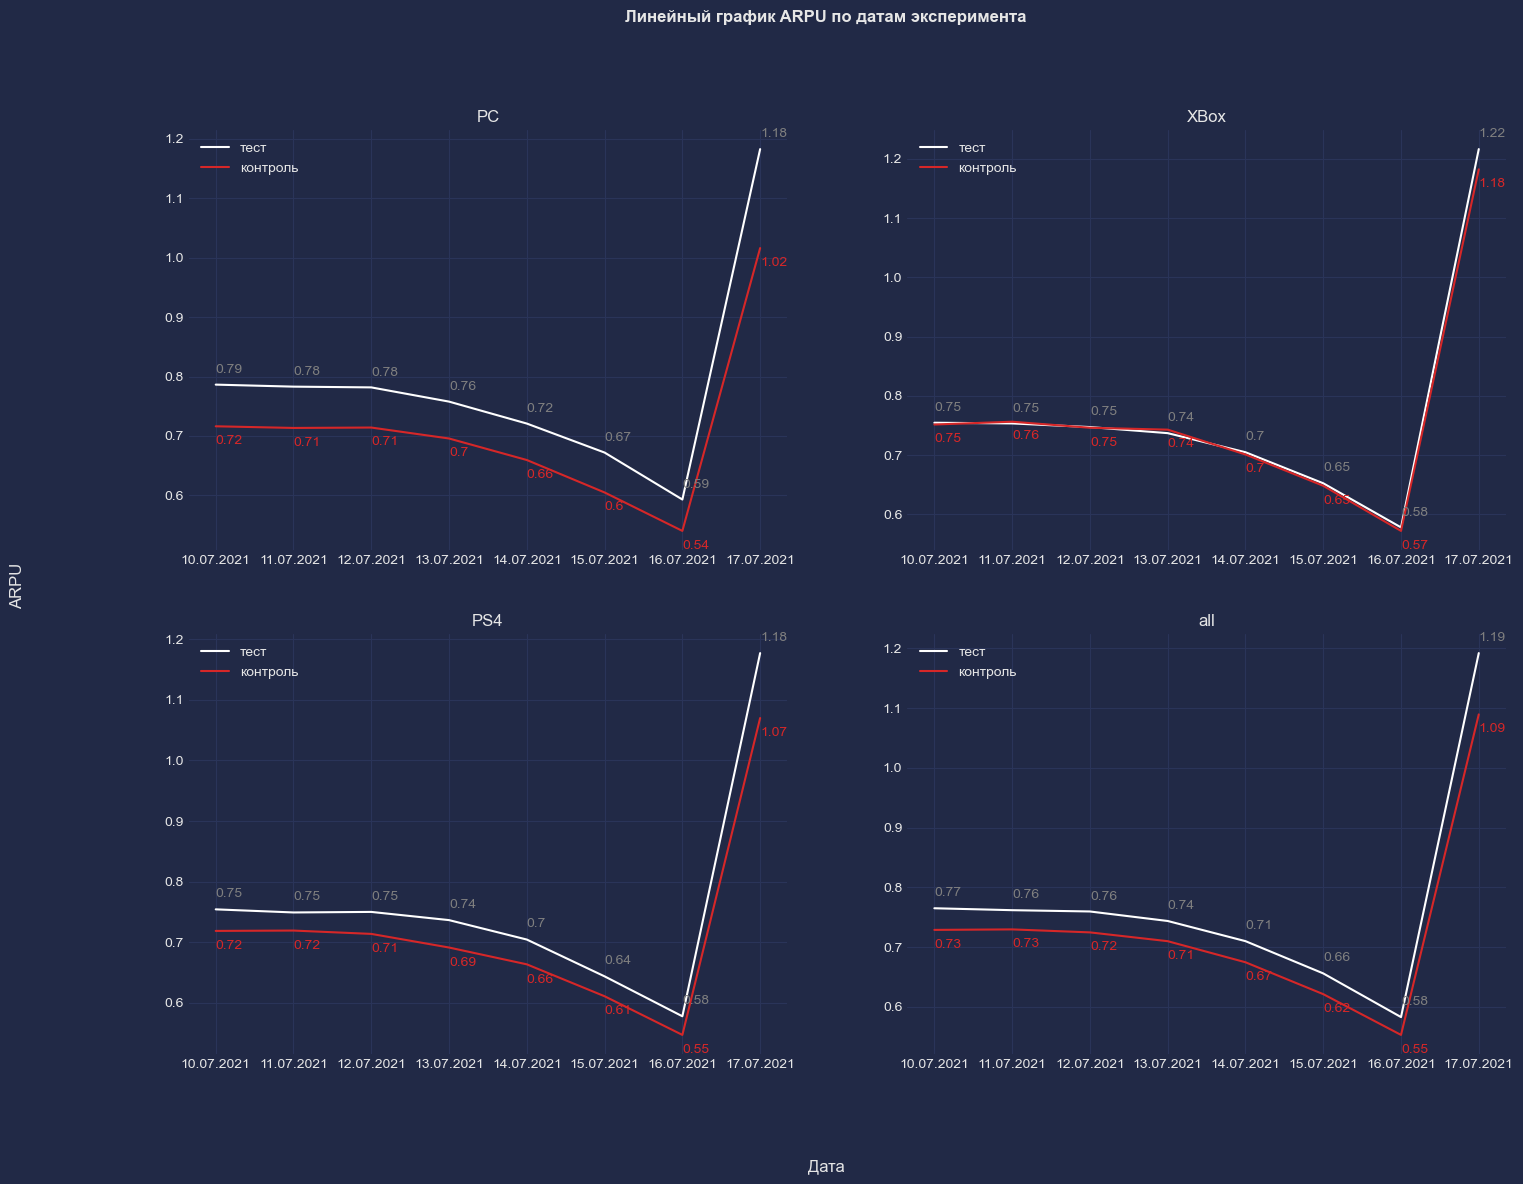

In [25]:
# ARPU временные ряды (линейный график)

f, axarr = plt.subplots(2, 2, figsize=(17, 12))

ARPU_all = ARPU.groupby(by = ['group', 'date']).ARPU.mean().reset_index()

ARPU_test_PC = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'PC')]
ARPU_control_PC = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'PC')]
ARPU_test_XBox = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'XBox')]
ARPU_control_XBox = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'XBox')]
ARPU_test_PS4 = ARPU[(ARPU['group'] == 'test') & (ARPU['platform'] == 'PS4')]
ARPU_control_PS4 = ARPU[(ARPU['group'] == 'control') & (ARPU['platform'] == 'PS4')]
ARPU_test_all = ARPU_all[(ARPU_all['group'] == 'test')]
ARPU_control_all = ARPU_all[(ARPU_all['group'] == 'control')]


# PC
axarr[0, 0].plot('date', 'ARPU', data=ARPU_test_PC, color='white', label='тест')
axarr[0, 0].plot('date', 'ARPU', data=ARPU_control_PC, color='tab:red', label='контроль')

for string in ARPU_test_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')
    
axarr[0, 0].title.set_text('PC')
axarr[0, 0].legend()


# XBox
axarr[0, 1].plot('date', 'ARPU', data=ARPU_test_XBox, color='white', label='тест')
axarr[0, 1].plot('date', 'ARPU', data=ARPU_control_XBox, color='tab:red', label='контроль')

for string in ARPU_test_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[0, 1].title.set_text('XBox')
axarr[0, 1].legend()
    
# PS4   
axarr[1, 0].plot('date', 'ARPU', data=ARPU_test_PS4, color='white', label='тест')
axarr[1, 0].plot('date', 'ARPU', data=ARPU_control_PS4, color='tab:red', label='контроль')

for string in ARPU_test_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPU_control_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[1, 0].title.set_text('PS4')
axarr[1, 0].legend()   

# all   
axarr[1, 1].plot('date', 'ARPU', data=ARPU_test_all, color='white', label='тест')
axarr[1, 1].plot('date', 'ARPU', data=ARPU_control_all, color='tab:red', label='контроль')

for string in ARPU_test_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] + 0.02), color='tab:grey')

for string in ARPU_control_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] - 0.03), color='tab:red')

axarr[1, 1].title.set_text('all')
axarr[1, 1].legend()


#plt.savefig('ARPU.png') # выгрузка картинки для блога

f.suptitle(fontweight='bold', t='Линейный график ARPU по датам эксперимента')
f.supxlabel('Дата')
f.supylabel('ARPU')
plt.show()

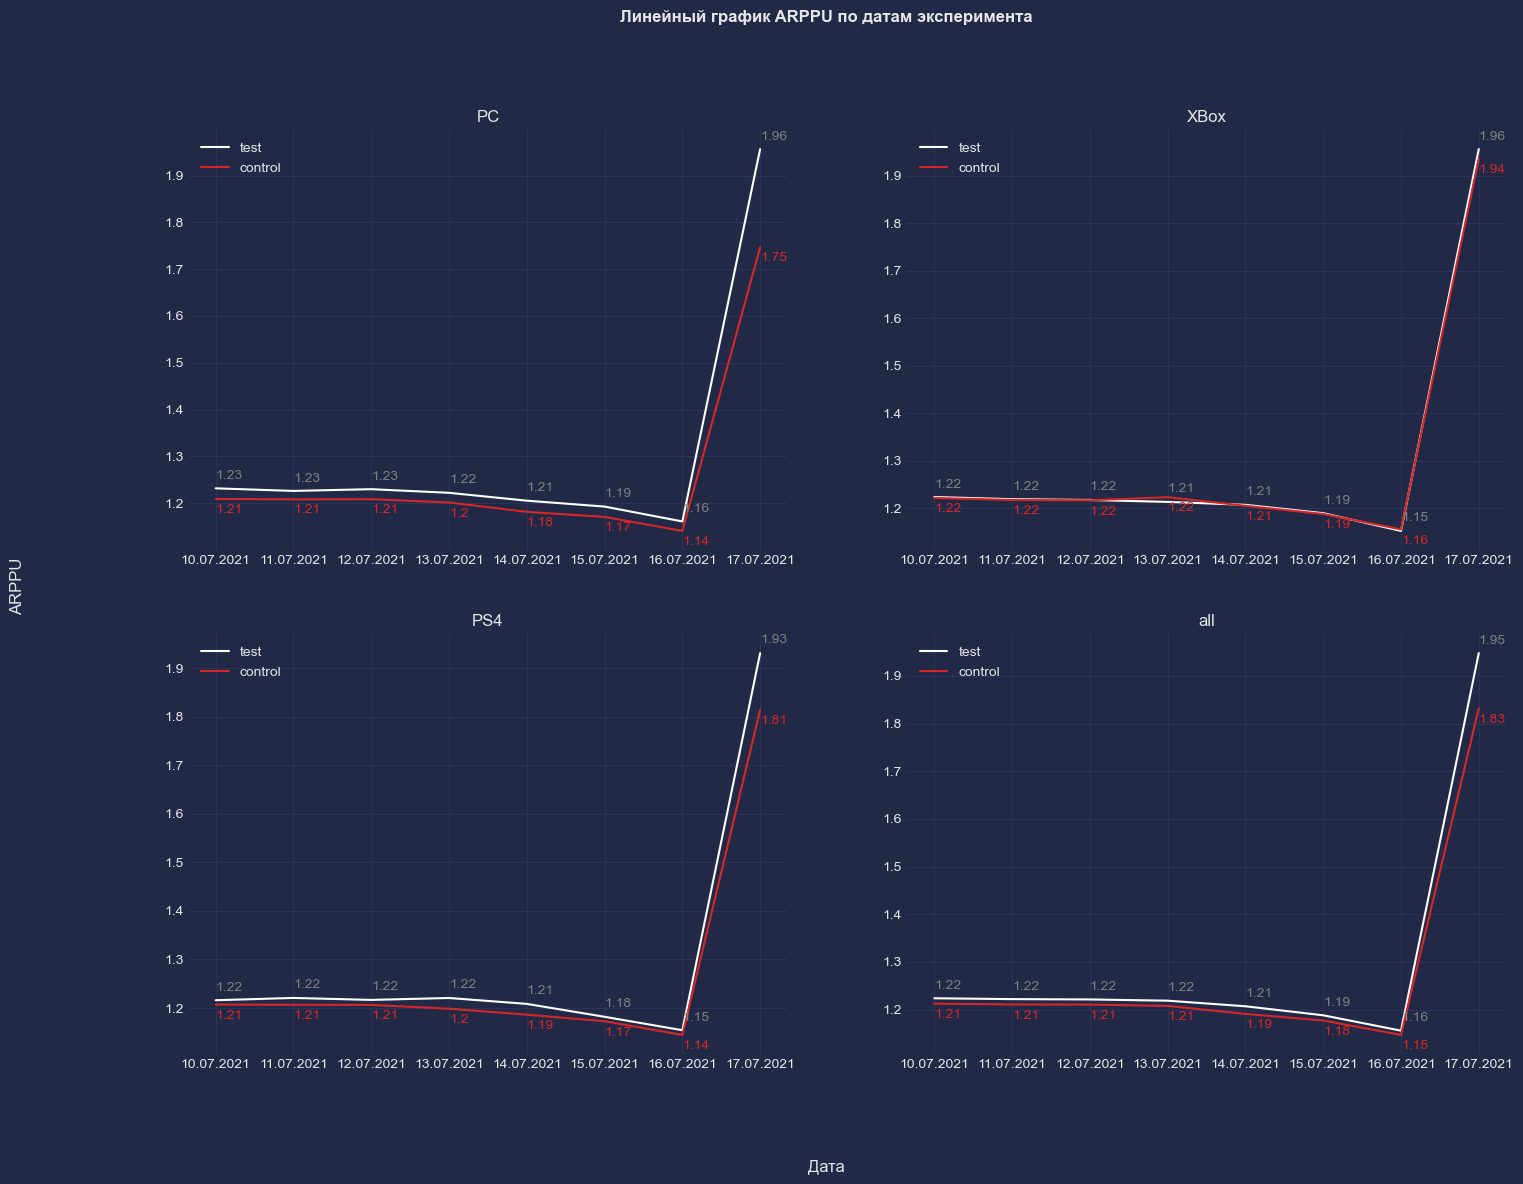

In [26]:
# ARPPU временные ряды

f, axarr = plt.subplots(2, 2, figsize=(17, 12))

ARPPU_all = ARPPU.groupby(by = ['group', 'date']).ARPPU.mean().reset_index()

ARPPU_test_PC = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'PC')]
ARPPU_control_PC = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'PC')]
ARPPU_test_XBox = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'XBox')]
ARPPU_control_XBox = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'XBox')]
ARPPU_test_PS4 = ARPPU[(ARPPU['group'] == 'test') & (ARPPU['platform'] == 'PS4')]
ARPPU_control_PS4 = ARPPU[(ARPPU['group'] == 'control') & (ARPPU['platform'] == 'PS4')]
ARPPU_test_all = ARPPU_all[(ARPPU_all['group'] == 'test')]
ARPPU_control_all = ARPPU_all[(ARPPU_all['group'] == 'control')]


# PC
axarr[0, 0].plot('date', 'ARPPU', data=ARPPU_test_PC, color='white', label='test')
axarr[0, 0].plot('date', 'ARPPU', data=ARPPU_control_PC, color='tab:red', label='control')

for string in ARPPU_test_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_PC.itertuples():
    axarr[0, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')
    
axarr[0, 0].title.set_text('PC')
axarr[0, 0].legend()


# XBox
axarr[0, 1].plot('date', 'ARPPU', data=ARPPU_test_XBox, color='white', label='test')
axarr[0, 1].plot('date', 'ARPPU', data=ARPPU_control_XBox, color='tab:red', label='control')

for string in ARPPU_test_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_XBox.itertuples():
    axarr[0, 1].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[0, 1].title.set_text('XBox')
axarr[0, 1].legend()
    
# PS4   
axarr[1, 0].plot('date', 'ARPPU', data=ARPPU_test_PS4, color='white', label='test')
axarr[1, 0].plot('date', 'ARPPU', data=ARPPU_control_PS4, color='tab:red', label='control')

for string in ARPPU_test_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] + 0.02), color='tab:grey')

for string in ARPPU_control_PS4.itertuples():
    axarr[1, 0].annotate(round(string[6], 2), xy=(string[2], string[6] - 0.03), color='tab:red')

axarr[1, 0].title.set_text('PS4')
axarr[1, 0].legend()   

# all   
axarr[1, 1].plot('date', 'ARPPU', data=ARPPU_test_all, color='white', label='test')
axarr[1, 1].plot('date', 'ARPPU', data=ARPPU_control_all, color='tab:red', label='control')

for string in ARPPU_test_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] + 0.02), color='tab:grey')

for string in ARPPU_control_all.itertuples():
    axarr[1, 1].annotate(round(string[3], 2), xy=(string[2], string[3] - 0.03), color='tab:red')

axarr[1, 1].title.set_text('all')
axarr[1, 1].legend()


#plt.savefig('ARPPU.png')

f.suptitle(fontweight='bold', t='Линейный график ARPPU по датам эксперимента')
f.supxlabel('Дата')
f.supylabel('ARPPU')

plt.show()


In [27]:
# рост метрик в среднем, за все дни эксперимента

metrics_dict = {}
metrics_result = pd.DataFrame()

ARPU_mean = ARPU.groupby(by='group').ARPU.mean()
ARPPU_mean = ARPPU.groupby(by='group').ARPPU.mean()

ARPU_mean_platform = ARPU.groupby(by=['group', 'platform']).ARPU.mean().reset_index()
ARPPU_mean_platform = ARPPU.groupby(by=['group', 'platform']).ARPPU.mean().reset_index()

# без разделения на платформы (т.е. в целом)
ARPU_dif_all = round(round(ARPU_mean['test'], 3) - round(ARPU_mean['control'], 3), 3)

metrics_dict['metric'] = 'ARPU'
metrics_dict['platform'] = 'all'
metrics_dict['increase'] = ARPU_dif_all
metrics_result = metrics_result._append(metrics_dict, ignore_index = True)


ARPPU_dif_all = round(round(ARPPU_mean['test'], 3) - round(ARPPU_mean['control'], 3), 3)

metrics_dict['metric'] = 'ARPPU'
metrics_dict['platform'] = 'all'
metrics_dict['increase'] = ARPPU_dif_all
metrics_result = metrics_result._append(metrics_dict, ignore_index = True)


# и по платформам
for data in [ARPU_mean_platform, ARPPU_mean_platform]:
    for platform in ['PC', 'PS4', 'XBox']:
        metrics = {}
        for group in ['control', 'test']:
            metric = str([column for column in data][2])
            metric_name = f'{metric}_{group}_{platform}'
            metric_value = list(data[(data['group'] == group) & (data['platform'] == platform)][metric])[0]
            metrics.update({metric_name: metric_value})
        diff = round(list(metrics.values())[1] - list(metrics.values())[0], 3)
        test_name = list(metrics.keys())[1]
        control_name = list(metrics.keys())[0]
        
        metrics_dict['metric'] = metric
        metrics_dict['platform'] = platform
        metrics_dict['increase'] = diff
        metrics_result = metrics_result._append(metrics_dict, ignore_index = True)

metrics_result = pd.DataFrame(metrics_result.groupby(by = ['metric', 'platform']).increase.sum())
metrics_result

increase
metric platform          
ARPPU  PC           0.045
       PS4          0.027
       XBox         0.002
       all          0.024
ARPU   PC           0.077
       PS4          0.045
       XBox         0.005
       all          0.042

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Вывод по метрикам</span></h3>
<p><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Так же как и с средней суммой, в метриках наблюдается рост - и по дням, и в целом за период проведения эксперимента, с учётом значительного скачка к концу эксперимента (видимо, выпало на выходные или есть другая причина). При этом так же группа платформы XBox демонстрирует слабую реакцию на акцию (вплоть до небольшого снижения метрик на 13.07), при масштабировании ей следует уделить особое внимание или скорректировать условия акции и провести повторный эксперимент.</span></p>

<h3 data-original-attrs="{&quot;style&quot;:&quot;&quot;}"><span data-keep-original-tag="false" data-original-attrs="{&quot;style&quot;:&quot;&quot;}">Общий вывод</span></h3>
<p></p>
<div>Акция рекомендована к масштабированию так как A/B-тест показал статистически значимый рост всех метрик по всем группам. В общем, метрики по платформам PC и PS4 приблизились к XBox, при этом сам XBox вырос не сильно.</div>
<p></p>